In [2]:
cd ..

c:\Users\janse\Documents\GitHub\ufc-match-predictor


In [40]:
import pandas
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from ufc.load_data import read_scraped_odds

In [4]:
odds_df = read_scraped_odds()

In [12]:
# Drop inf rows
odds_df = odds_df[
    ~(
        (odds_df["fighter1_odds"] == np.inf) | (odds_df["fighter2_odds"] == np.inf)
    )
]

In [34]:
# Recode to favourite vs underdog
# Where equal odds - we will consider fighter1 as the favourite (minority of cases so fine to include for modelling)
odds_df["favourite"] = np.where(odds_df["fighter1_odds"] <= odds_df["fighter2_odds"], odds_df["fighter1"], odds_df["fighter2"])
odds_df["underdog"] = np.where(odds_df["fighter1_odds"] > odds_df["fighter2_odds"], odds_df["fighter1"], odds_df["fighter2"])
odds_df["outcome"] = np.where(odds_df["result"] == odds_df["favourite"], "favourite", "underdog")

In [32]:
# % of fights where favourite won
(
    odds_df
    .groupby("outcome", as_index=False)
    .agg(n = ('outcome', 'count'))
    .assign(pct = lambda df: df["n"] / sum(df["n"]))
)

,outcome,n,pct
0,favourite,1402,0.340788
1,underdog,2712,0.659212


Relationship between delta of odds and likelihood of favourite winning

In [38]:
odds_df["delta_odds"] = abs(odds_df["fighter1_odds"] - odds_df["fighter2_odds"])

In [109]:
plot_df = odds_df.copy()
plot_df["delta_odds_bin"] = pd.cut(plot_df['delta_odds'], bins=15)

plot_df = (
    plot_df
    .groupby(["delta_odds_bin"], as_index=False)
    .agg(
        n = ('outcome', lambda x: x.count()),
        pct_fav_win = ('outcome', lambda x: (x == "favourite").sum() / x.count())
    )
)

plot_df = plot_df.sort_values(by='delta_odds_bin')

plot_df['delta_odds_bin'] = plot_df['delta_odds_bin'].astype(str)


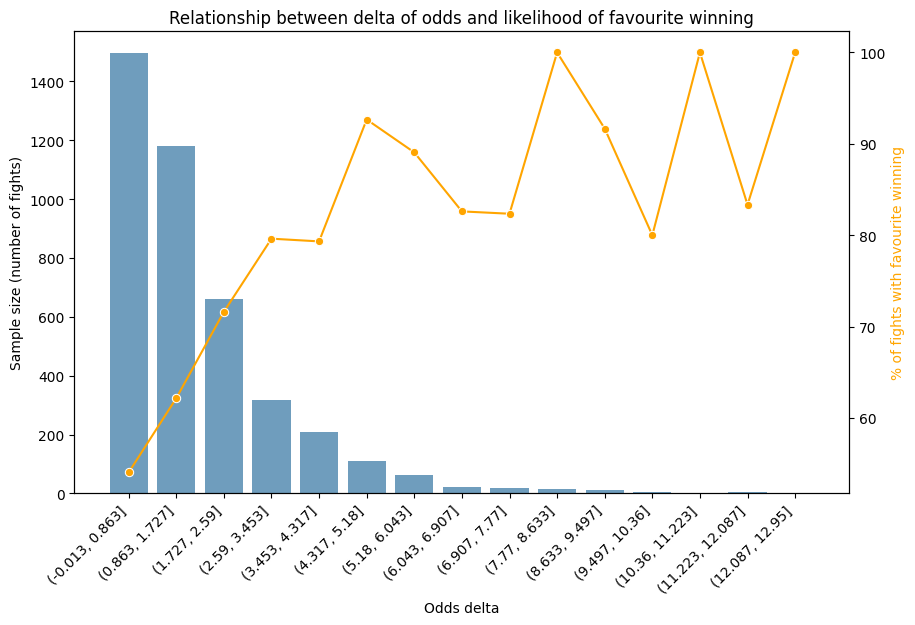

In [116]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x=plot_df['delta_odds_bin'], y=plot_df['n'], alpha=0.7, ax=ax1, zorder=2)
ax1.set_ylabel('Sample size (number of fights)')
ax1.set_xlabel('Odds delta')
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()

sns.lineplot(x=plot_df['delta_odds_bin'], y=plot_df['pct_fav_win'] * 100, marker='o', color='orange', ax=ax2, zorder=3)
ax2.set_ylabel('% of fights with favourite winning', color='orange')

plt.title("Relationship between delta of odds and likelihood of favourite winning")

plt.show()
